## Part 2a prepare annotation 

In this notebook we load the **allntova** (**A**ll cells, **N**ot aPD1 **T**reated, p**OVA** immunogenic tumor) dataset from Seurat. In addition, we prepare reference scRNA-seq datasets that are used to annotate and validate cell state annotation of the allntova dataset. We use the following reference datasets: 
- Miller et al., 2019 (both tumor & LCMV): https://doi.org/10.1038/s41590-019-0312-6
- Zilionis et al., 2019 (from our lab): https://doi.org/10.1016/j.immuni.2019.03.009
- Maier et al., 2020: https://doi.org/10.1038/s41586-020-2134-y
- Zhang et al., 2020 (only MC38 tumors): https://doi.org/10.1016/j.cell.2020.03.048
- ImmGen consortium: http://www.immgen.org

In [3]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import anndata
import itertools
import functools
from time import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import multiprocessing
import loompy
import mygene 
import mm_functions_14_10_2020 as mm
mg = mygene.MyGeneInfo()

In [6]:
# Set figure parameters 
mylines = 0.15*2.82 # the number 2.82 is the difference
					# between Illustrator 1 pt and python 1 pt.
mpl.rcParams['axes.linewidth'] = mylines # default 1
mpl.rcParams['ytick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.major.size'] = 2 # default 4
mpl.rcParams['ytick.major.size'] = 2 # default 4
mpl.rcParams['xtick.major.width'] = mylines # default 0.5
mpl.rcParams['ytick.major.width'] = mylines # default 0.5
mpl.rcParams['grid.linewidth'] = mylines/1.5 # default 0.5
mpl.rcParams['grid.color'] = '0.8' # default 'k'
mpl.rcParams['grid.linestyle'] = 'solid'# default ':'
mpl.rcParams['legend.frameon'] = False # default True
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
adata = {}

## Load allntova 

In [9]:
# the .loom format is used to convert between the Seurat allntova object and a Scanpy anndata object 
adata['allntova'] = sc.read_loom('/Users/mariusmessemaker/Documents/Project/mempel/ctrlImmunogenicAllCellsCorrected.loom')

# Change the PCA and umap keys to Scanpy readable format: 
adata['allntova'].obsm['X_pca'] = adata['allntova'].obsm.pop('pca_cell_embeddings')
adata['allntova'].obsm['X_umap'] = adata['allntova'].obsm.pop('umap_cell_embeddings')

In [10]:
# Convert the ensembl gene ID to gene symbol 
gene_convert_list = mg.querymany(adata['allntova'].var_names, scopes='ensembl.gene', fields='symbol', species='mouse')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20834...done.
Finished.
158 input query terms found no hit:
	['ENSMUSG00000034007', 'ENSMUSG00000062382', 'ENSMUSG00000070511', 'ENSMUSG00000074873', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [11]:
var_names_map = {}
query_names_map = {}

for item in gene_convert_list:
    ensembl = item.pop('query')
    query_names_map[ensembl] = item 

for ensembl in query_names_map.keys():
    for key, value in query_names_map[ensembl].items():
        if key == 'symbol':
            var_names_map[ensembl] = value

In [12]:
print('Shape adata before converting ensembl to gene symbols', adata['allntova'].shape)
adata['allntova'] = adata['allntova'][:, ~adata['allntova'].var_names.map(var_names_map).isna()].copy()
adata['allntova'].var_names = adata['allntova'].var_names.map(var_names_map)
print('Shape adata after converting ensembl to gene symbols', adata['allntova'].shape)

Shape adata before converting ensembl to gene symbols (8757, 20834)


/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Shape adata after converting ensembl to gene symbols (8757, 20676)


In [13]:
# test that all genes were converted 
print(all(pd.DataFrame(var_names_map.values()).isin(adata['allntova'].var_names)[0]))
print(all(~adata['allntova'].var_names.str.startswith('ENSMUS')))

True
True


In [14]:
print(adata['allntova'].var_names.is_unique)
adata['allntova'].var_names_make_unique()
print(adata['allntova'].var_names.is_unique)

False
True


In [15]:
# adata.X counts are SCTransform corrected UMI counts (calculated from the pearson residuals) without added pseudo value
print('total counts per cell:')
print(adata['allntova'].X.sum(1)[:5])
print('min value:')
print(adata['allntova'].X.min())

total counts per cell:
[[1165.]
 [1131.]
 [1129.]
 [1065.]
 [1010.]]
min value:
0.0


In [16]:
# James: "The range of counts per UMI for the SCT slot is 0:187"
# This confirms the counts in .X are the right SCTransform corrected UMI counts in the SCT @counts slot:
# https://satijalab.org/seurat/v3.1/sctransform_vignette.html
print(adata['allntova'].X.min())
print(adata['allntova'].X.max())

0.0
187.0


In [17]:
# Compute a neighborhood graph directly from Seurat PCA embeddings
sc.pp.neighbors(adata['allntova'], n_pcs = 15)

In [18]:
# Create microclusters of ~ 20 cells for neighbor smoothing  
sc.tl.leiden(adata['allntova'], resolution = 48.75, key_added = 'sc_leiden_res_48.75')
print(adata['allntova'].obs['sc_leiden_res_48.75'].unique())
print(adata['allntova'].shape[0]/436)

['5', '112', '215', '84', '224', ..., '183', '295', '58', '239', '300']
Length: 436
Categories (436, object): ['5', '112', '215', '84', ..., '295', '58', '239', '300']
20.084862385321102


In [ ]:
adata['allntova'].write('./backups/adata_allntova_05302020.h5ad')

## Load Zilionis 

In [19]:
# From https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE127465 download .mtx: 
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE127465&format=file&file=GSE127465%5Fmouse%5Fcounts%5Fnormalized%5F15939x28205%2Emtx%2Egz
# Read into AnnData 2 (adata2)
adata['zilionis'] = sc.read_mtx('/Users/mariusmessemaker/Documents/Project/Siglec-proteinVSmRNA/GSE127465_mouse_counts_normalized_15939x28205.mtx')

# Also download meta .tsv: 
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE127465&format=file&file=GSE127465%5Fmouse%5Fcell%5Fmetadata%5F15939x12%2Etsv%2Egz
# Read into AnnData 2 (adata2.obs):
adata['zilionis'].obs = pd.read_csv('/Users/mariusmessemaker/Documents/Project/Siglec-proteinVSmRNA/GSE127465_mouse_cell_metadata_15939x12.tsv', sep = '\t')

# Lastly, download gene names .tsv: 
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE127465&format=file&file=GSE127465%5Fgene%5Fnames%5Fmouse%5F28205%2Etsv%2Egz
# Read into AnnData 2 (adata2.var_names): 
adata['zilionis'].var_names = pd.read_csv('/Users/mariusmessemaker/Documents/Project/Siglec-proteinVSmRNA/GSE127465_gene_names_mouse_28205.tsv', sep = '\t', header = None)[0]

In [20]:
# Zilionis is total counts normalized without pseudo value added 
print('total counts per cell:')
print(adata['zilionis'].X.sum(1)[:5])
print('min value:')
print(adata['zilionis'].X.min())

total counts per cell:
[[2434.6206]
 [2434.6204]
 [2434.62  ]
 [2434.6204]
 [2434.62  ]]
min value:
0.0


In [21]:
# Rename state column 
adata['zilionis'].obs.rename({'Minor subset': 'state'}, axis=1, inplace = True)
adata['zilionis'].obs

,Tumor or healthy,Biological replicate,Library,Barcode,Library prep batch,Total counts,Percent counts from mitochondrial genes,Most likely Immgen cell type,Major cell type,state,x,y
0,t,Tumor-bearing 1,t_1_1,bc0001,round1_20151128,7927.0,3.393000,MF_Thio5_II+480int_PC,MoMacDC,Mac1,1174.120533,-217.075559
1,t,Tumor-bearing 1,t_1_1,bc0002,round1_20151128,5665.0,6.461000,DC_103-11b+24+_Lu,MoMacDC,DC1,1068.808968,-37.966851
2,t,Tumor-bearing 1,t_1_1,bc0003,round1_20151128,4615.0,2.579000,DC_8-4-11b+_SLN,MoMacDC,DC3,791.206113,-51.756695
3,t,Tumor-bearing 1,t_1_1,bc0004,round1_20151128,5353.0,3.082000,DC_8+_Th,MoMacDC,DC1,1068.688851,-17.459386
4,t,Tumor-bearing 1,t_1_1,bc0005,round1_20151128,4653.0,2.901000,DC_8-4-11b+_SLN,MoMacDC,DC3,805.516538,-52.706709
...,...,...,...,...,...,...,...,...,...,...,...,...
15934,t,Tumor-bearing 2,t_2_4,bc1083,round3_20160313,1082.0,6.561922,T_8Nve_Sp_OT1,T cells,T1,722.864953,622.365393
15935,t,Tumor-bearing 2,t_2_4,bc1084,round3_20160313,912.0,3.837719,B_Fo_Sp,B cells,B cells,240.758904,292.600115
15936,t,Tumor-bearing 2,t_2_4,bc1085,round3_20160313,926.0,5.507559,GN_UrAc_PC,Neutrophils,N4,1037.348649,-796.034347
15937,t,Tumor-bearing 2,t_2_4,bc1086,round3_20160313,795.0,0.628931,GN_Arth_SynF,Neutrophils,N3,413.387190,-650.431908


In [ ]:
adata['zilionis'].write('./backups/adata_zilionis_05202020.h5ad')

## Load Maier

In [22]:
# Load Maier 
maier = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/maier/GSM3832737_wt_tumor_gex.csv', index_col = 0).T
maier_index = maier.index
maier_var_names = maier.columns.values
maier_meta = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/maier/GSE131957_single_cell_metadata.csv', index_col = 0).T

In [23]:
# Store into anndata 
adata['maier'] = anndata.AnnData(X = sp.sparse.csr_matrix(maier.values))
adata['maier'].obs.index = maier_index
adata['maier'].var_names = maier_var_names

In [24]:
maier_meta

,sample,nUMI_mRNA,%mito,pdc_filt_score,QC_pass,cluster,cluster_annotation
wt_naive_AAACCTGAGGGATCTG,wt_naive,6954,1.82628702904803,0,TRUE,4,DC1
wt_naive_AAACCTGCACATAACC,wt_naive,786,37.9134860050891,0,FALSE,NaN,NaN
wt_naive_AAACCTGGTTGCGCAC,wt_naive,6815,1.36463683052091,0.000146735143066764,TRUE,4,DC1
wt_naive_AAACCTGTCAGGCCCA,wt_naive,536,28.544776119403,0,FALSE,NaN,NaN
wt_naive_AAACCTGTCAGTGCAT,wt_naive,11013,1.97039861981295,0.00036320711885953,TRUE,4,DC1
...,...,...,...,...,...,...,...
ccr7ko_tumor_TTTGTCACAATAGCGG,ccr7ko_tumor,7764,2.344152498712,0.000128799587841319,TRUE,3,DC2
ccr7ko_tumor_TTTGTCACAGCTGCTG,ccr7ko_tumor,333,54.954954954955,0,FALSE,NaN,NaN
ccr7ko_tumor_TTTGTCAGTGTTAAGA,ccr7ko_tumor,4678,3.35613510047029,0,TRUE,3,DC2
ccr7ko_tumor_TTTGTCATCAAACCAC,ccr7ko_tumor,1433,8.23447313328681,0,TRUE,3,DC2


In [25]:
# Store Maier meta into .obs 
adata['maier'].obs = adata['maier'].obs.join(maier_meta)

In [26]:
adata['maier'].obs

,sample,nUMI_mRNA,%mito,pdc_filt_score,QC_pass,cluster,cluster_annotation
wt_tumor_AAACCTGAGGGCTTGA,wt_tumor,274,9.12408759124088,0,FALSE,NaN,NaN
wt_tumor_AAACCTGAGTTTGCGT,wt_tumor,13494,2.31954942937602,0.000370535052615977,TRUE,1,mac&contam
wt_tumor_AAACCTGGTCCTAGCG,wt_tumor,7224,0.81672203765227,0.000138427464008859,TRUE,5,mregDC
wt_tumor_AAACCTGGTGCCTGTG,wt_tumor,7005,2.16987865810136,0.000285510349750178,TRUE,3,DC2
wt_tumor_AAACCTGTCACGATGT,wt_tumor,6994,1.55847869602516,0.00142979696883043,TRUE,2,mac&contam
...,...,...,...,...,...,...,...
wt_tumor_TTTGTCAAGGTGCTTT,wt_tumor,16055,0.753659296169418,0.000249143568981626,TRUE,3,DC2
wt_tumor_TTTGTCACATCGTCGG,wt_tumor,7485,2.5250501002004,0.00053440213760855,TRUE,2,mac&contam
wt_tumor_TTTGTCAGTAATCGTC,wt_tumor,9422,0.902143918488644,0.000530672893228614,TRUE,5,mregDC
wt_tumor_TTTGTCAGTTATGCGT,wt_tumor,4494,5.18469069870939,0.000222518914107699,TRUE,1,mac&contam


In [27]:
adata['maier'] = adata['maier'][adata['maier'].obs['cluster_annotation'].isin(['mregDC', 'DC2', 'DC1'])].copy()

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [28]:
adata['maier'].obs['cluster_annotation'].unique()

array(['mregDC', 'DC2', 'DC1'], dtype=object)

In [29]:
adata['maier'].obs['QC_pass'].unique()

array(['TRUE'], dtype=object)

In [30]:
# Maier counts are not normalized without pseudo value added 
print('total counts per cell:')
print(adata['maier'].X.sum(1)[:5])
print('min value:')
print(adata['maier'].X.min())

total counts per cell:
[[7224.]
 [7005.]
 [4866.]
 [5426.]
 [4315.]]
min value:
0.0


In [31]:
adata['maier'].obs['nUMI_mRNA']

wt_tumor_AAACCTGGTCCTAGCG     7224
wt_tumor_AAACCTGGTGCCTGTG     7005
wt_tumor_AAACCTGTCTACTCAT     4866
wt_tumor_AAACGGGAGACTGGGT     5426
wt_tumor_AAACGGGGTATAAACG     4315
                             ...  
wt_tumor_TTTGCGCGTGCCTGCA    12836
wt_tumor_TTTGGTTAGATATACG    14524
wt_tumor_TTTGGTTCAGCTTCGG     7620
wt_tumor_TTTGTCAAGGTGCTTT    16055
wt_tumor_TTTGTCAGTAATCGTC     9422
Name: nUMI_mRNA, Length: 1468, dtype: object

In [32]:
adata['maier'].X.sum(1).mean()

8049.111

In [33]:
sc.pp.normalize_total(adata['maier'], target_sum = adata['maier'].X.sum(1).mean())
print('total counts per cell:')
print(adata['maier'].X.sum(1)[:5])
print('min value:')
print(adata['maier'].X.min())

total counts per cell:
[[8049.1113]
 [8049.1104]
 [8049.111 ]
 [8049.1104]
 [8049.1113]]
min value:
0.0


In [34]:
# Rename 'cluster_annotation' column to 'state'
adata['maier'].obs.rename({'cluster_annotation': 'state'}, axis=1, inplace = True)
adata['maier'].obs

,sample,nUMI_mRNA,%mito,pdc_filt_score,QC_pass,cluster,state
wt_tumor_AAACCTGGTCCTAGCG,wt_tumor,7224,0.81672203765227,0.000138427464008859,TRUE,5,mregDC
wt_tumor_AAACCTGGTGCCTGTG,wt_tumor,7005,2.16987865810136,0.000285510349750178,TRUE,3,DC2
wt_tumor_AAACCTGTCTACTCAT,wt_tumor,4866,2.75380189066995,0,TRUE,3,DC2
wt_tumor_AAACGGGAGACTGGGT,wt_tumor,5426,1.78768890527092,0.000184297825285662,TRUE,3,DC2
wt_tumor_AAACGGGGTATAAACG,wt_tumor,4315,4.00926998841251,0.000695249130938586,TRUE,4,DC1
...,...,...,...,...,...,...,...
wt_tumor_TTTGCGCGTGCCTGCA,wt_tumor,12836,2.97600498597694,0.000311623558741041,TRUE,3,DC2
wt_tumor_TTTGGTTAGATATACG,wt_tumor,14524,1.76948499036078,0.000413109336271,TRUE,4,DC1
wt_tumor_TTTGGTTCAGCTTCGG,wt_tumor,7620,1.58792650918635,0.0005249343832021,TRUE,3,DC2
wt_tumor_TTTGTCAAGGTGCTTT,wt_tumor,16055,0.753659296169418,0.000249143568981626,TRUE,3,DC2


In [ ]:
adata['maier'].write('./backups/adata_maier_05202020.h5ad')

## Load Zhang 

In [35]:
#aCD40 
adata['zhangcd40'] = sc.read_mtx('/Users/mariusmessemaker/Documents/Project/mempel/data/zhangcrc/CD40_raw_UMI.mtx').transpose()

adata['zhangcd40'].obs = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/zhangcrc/CD40_raw_UMI_barcodes.tsv')
adata['zhangcd40'].obs.rename({'x': 'barcodes'}, axis=1, inplace = True)
adata['zhangcd40'].obs.index = adata['zhangcd40'].obs['barcodes'].str.split('\"').str[1]
adata['zhangcd40'].obs = adata['zhangcd40'].obs.join(pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/zhangcrc/CD40_metadata.csv', index_col = 0))
adata['zhangcd40'].obs.drop(['barcodes', 'CellName'], inplace = True, axis = 1)
adata['zhangcd40'].obs.rename({'Sub_Cluster': 'State'}, axis=1, inplace = True)

adata['zhangcd40'].var_names = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/zhangcrc/CD40_raw_UMI_genes.tsv')['x'].str.split('\"').str[1]

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
# zhangcd40 data is unnormalized and no pseudocount was added 
print('total counts per cell:')
print(adata['zhangcd40'].X.sum(1)[:5])
print('min value:')
print(adata['zhangcd40'].X.min())

total counts per cell:
[[ 6108.]
 [ 4776.]
 [ 5934.]
 [10039.]
 [ 6666.]]
min value:
0.0


In [37]:
sc.pp.normalize_total(adata['zhangcd40'], target_sum = adata['zhangcd40'].X.sum(1).mean())
print('total counts per cell:')
print(adata['zhangcd40'].X.sum(1)[:5])
print('min value:')
print(adata['zhangcd40'].X.min())

total counts per cell:
[[5864.042 ]
 [5864.0405]
 [5864.0415]
 [5864.0405]
 [5864.041 ]]
min value:
0.0


In [ ]:
adata['zhangcd40'].write('./backups/adata_zhangcd40_05202020.h5ad')

## Load Miller 

In [38]:
adata['miller'] = sc.read_loom('/Users/mariusmessemaker/Documents/Project/mempel/data/miller/b16_d20.loom')

adata['miller'].obsm['X_pca'] = adata['miller'].obsm.pop('pca_cell_embeddings')
adata['miller'].obsm['X_umap'] = adata['miller'].obsm.pop('tsne_cell_embeddings')

In [39]:
adata['miller'].obs['ClusterID'] = adata['miller'].obs['ClusterID'].astype('category')
adata['miller'].obs['ClusterName'] = adata['miller'].obs['ClusterName'].astype('category')

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig_ident' as categorical
... storing 'res_0_4' as categorical
... storing 'res_0_5' as categorical
... storing 'res_0_6' as categorical


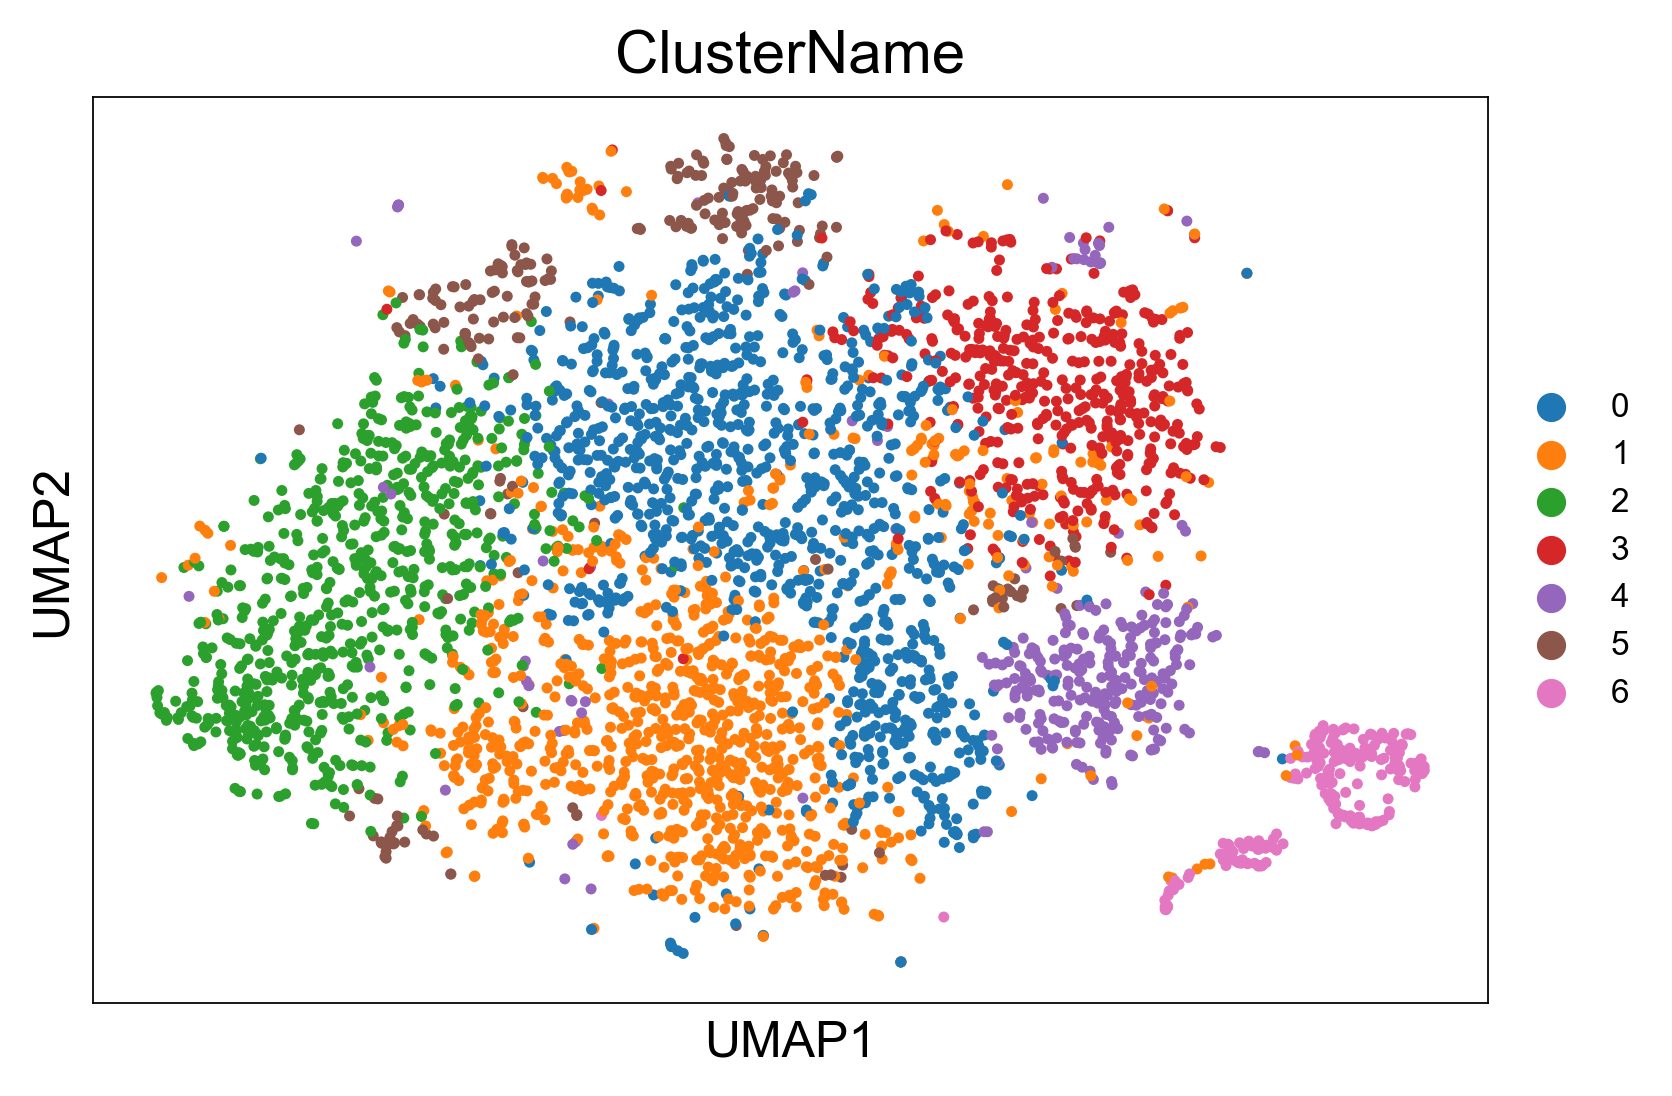

In [40]:
sc.pl.umap(adata['miller'], color = 'ClusterName', legend_fontsize = 8)

In [41]:
miller_cluster_map = {
    '0': 'CD8 T E', 
    '1': 'CD8 T E',
    '2': 'CD8 T E',
    '3': 'CD8 T E',
    '4': 'CD8 T E',
    '5': 'CD8 T P E',
    '6': 'grey' 
}

In [42]:
adata['miller'].obs['state'] = adata['miller'].obs['ClusterName'].map(miller_cluster_map)

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'state' as categorical


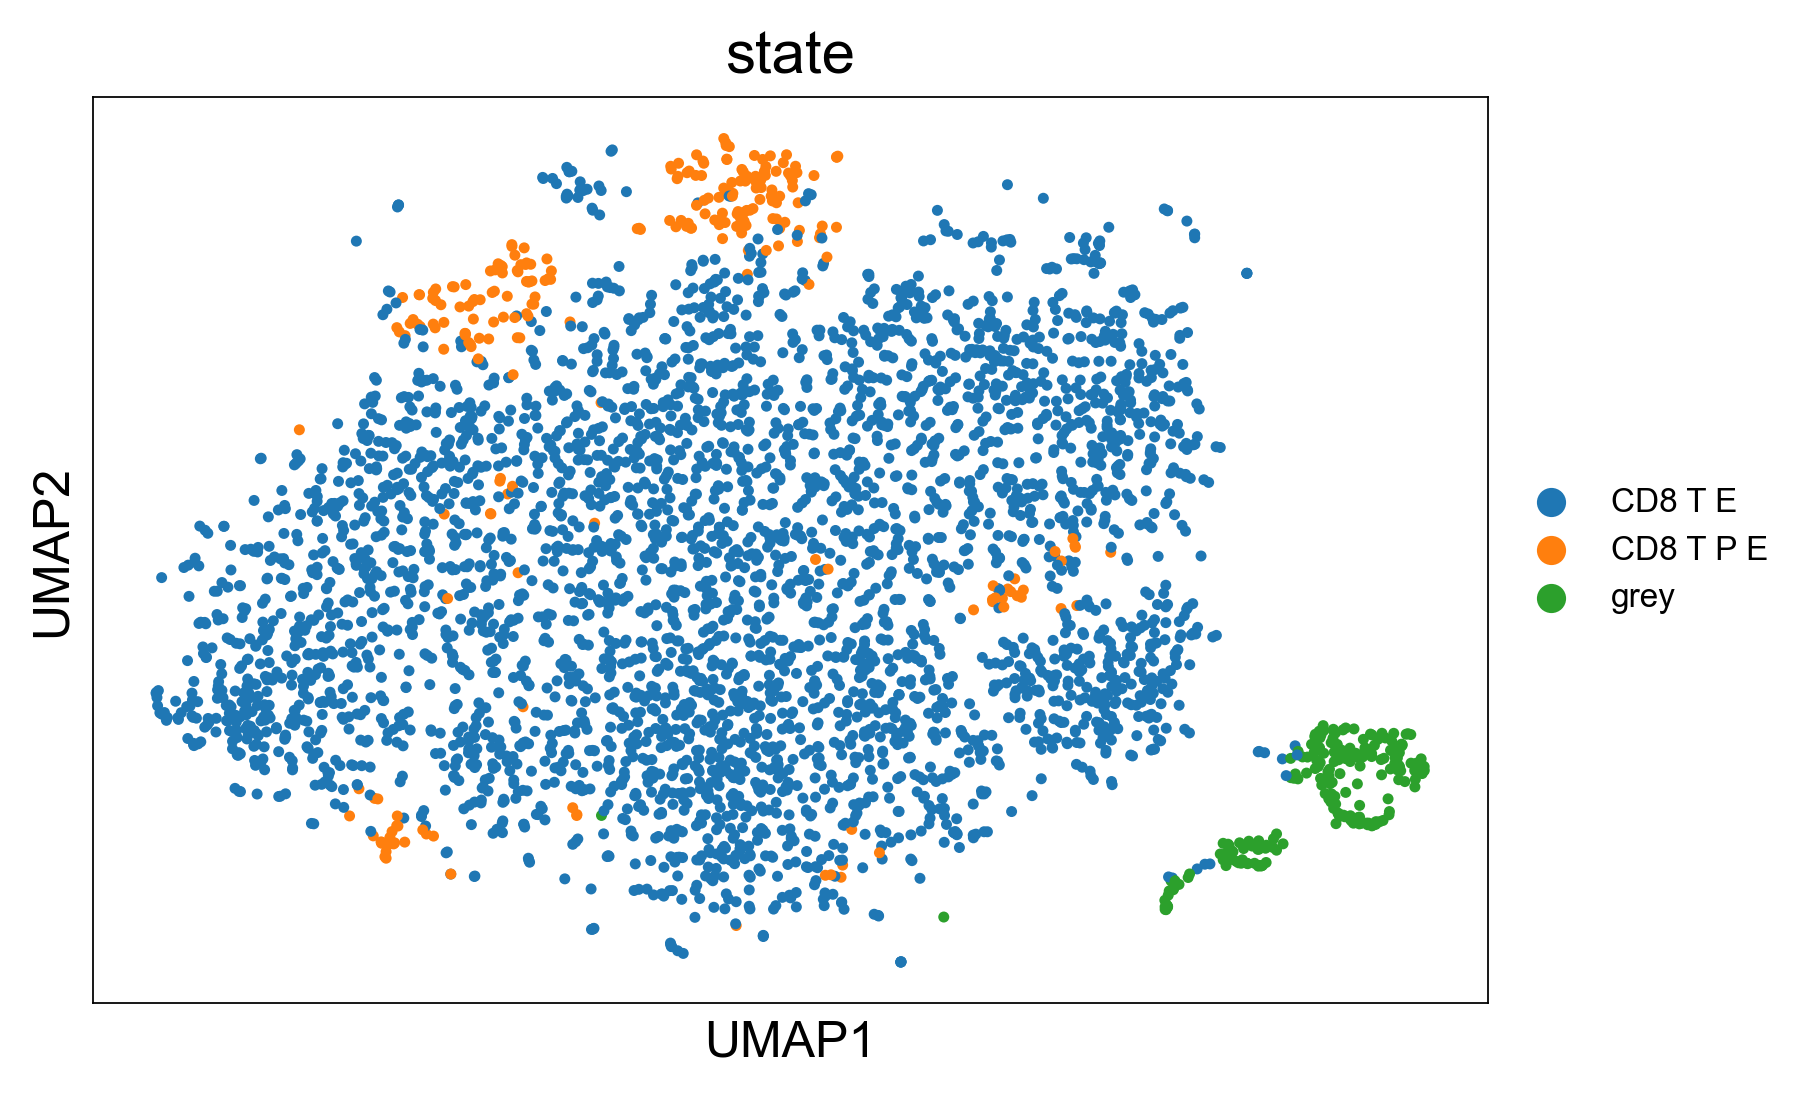

In [43]:
sc.pl.umap(adata['miller'], color = 'state', legend_fontsize = 8)

In [44]:
# Miller data is unnormalized and no pseudocount was added 
print('total counts per cell:')
print(adata['miller'].X.sum(1)[:5])
print('min value:')
print(adata['miller'].X.min())

total counts per cell:
[[14572.]
 [28798.]
 [ 5706.]
 [ 6359.]
 [12596.]]
min value:
0.0


In [45]:
sc.pp.normalize_total(adata['miller'], target_sum = adata['miller'].X.sum(1).mean())
print('total counts per cell:')
print(adata['miller'].X.sum(1)[:5])
print('min value:')
print(adata['miller'].X.min())

total counts per cell:
[[10863.693]
 [10863.694]
 [10863.693]
 [10863.694]
 [10863.694]]
min value:
0.0


In [6]:
adata['millerlcmv'] = sc.read_mtx('/Users/mariusmessemaker/Documents/Project/mempel/data/miller/GSE122712_matrix.mtx').transpose()
adata['millerlcmv'].obs = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/miller/GSE122712_barcodes.tsv', header = None)
adata['millerlcmv'].var_names = pd.read_csv('/Users/mariusmessemaker/Documents/Project/mempel/data/miller/GSE122712_genes.tsv', header = None, delimiter = '\t')[1]
adata['millerlcmv'].obs.columns = ['cell_barcode']
adata['millerlcmv'].obs.set_index('cell_barcode', drop = True, inplace = True)

In [7]:
millerlcmv_meta = pd.DataFrame(np.loadtxt('/Users/mariusmessemaker/Documents/Project/mempel/data/miller/LCMV_cluster_ID.txt', dtype = str))
millerlcmv_meta.columns = ['cell_barcode', 'cluster']
millerlcmv_meta.set_index('cell_barcode', drop = True, inplace = True)

In [8]:
adata['millerlcmv'].obs = adata['millerlcmv'].obs.join(millerlcmv_meta)

In [9]:
print('Shape adata before removing bad cells', adata['millerlcmv'].shape)
adata['millerlcmv'] = adata['millerlcmv'][~adata['millerlcmv'].obs['cluster'].isna(), :].copy()
print('Shape adata after removing bad cells', adata['millerlcmv'].shape)

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Shape adata before removing bad cells (9197, 27998)
Shape adata after removing bad cells (9194, 27998)


In [10]:
# Var_names are duplicated 
print(adata['millerlcmv'].var_names.is_unique)
adata['millerlcmv'].var_names_make_unique()
print(adata['millerlcmv'].var_names.is_unique)

False
True


In [11]:
adata['millerlcmv'].obs['cluster'].unique()

array(['1', '0', '2', '3', '4'], dtype=object)

In [12]:
millerlcmv_cluster_map = {
'0' : 'CD8 T Ef',
'1' : 'CD8 T E', 
'2': 'CD8 T P', 
'3': 'CD8 T Pr', 
'4': 'Cluster 3'
}

In [13]:
adata['millerlcmv'].obs['state'] = adata['millerlcmv'].obs['cluster'].map(millerlcmv_cluster_map)

In [14]:
# Millerlcmv data is unnormalized and no pseudocount was added 
print('total counts per cell:')
print(adata['millerlcmv'].X.sum(1)[:5])
print('min value:')
print(adata['millerlcmv'].X.min())

total counts per cell:
[[1689.]
 [2651.]
 [2828.]
 [2846.]
 [2499.]]
min value:
0.0


In [15]:
sc.pp.normalize_total(adata['millerlcmv'], target_sum = adata['millerlcmv'].X.sum(1).mean())
print('total counts per cell:')
print(adata['millerlcmv'].X.sum(1)[:5])
print('min value:')
print(adata['millerlcmv'].X.min())

total counts per cell:
[[3223.1682]
 [3223.168 ]
 [3223.168 ]
 [3223.1682]
 [3223.1682]]
min value:
0.0


In [ ]:
# Write Miller
adata['miller'].write('./backups/adata_' + 'miller' + '_05202020.h5ad')
adata['millerlcmv'].write('./backups/adata_' + 'millerlcmv' + '_05202020.h5ad')